# Object recognition in pytorch

Pytorch is our trusty counterpart to keras/tensorflow, and since both are in use in the world of **deep learning**, we'll let you have a go with pytorch as well!

We'll go through the steps pretty quickly, together!

## examining the data

In [1]:
!wget -N https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dog.npy -P ../assets/
!wget -N https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy -P ../assets/

--2021-04-15 10:18:58--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dog.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.27.128, 142.250.102.128, 2a00:1450:4025:402::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.27.128|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘../assets/dog.npy’ not modified on server. Omitting download.

--2021-04-15 10:18:58--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.27.128, 142.250.102.128, 2a00:1450:4025:402::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.27.128|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘../assets/cat.npy’ not modified on server. Omitting download.



In [2]:
import numpy as np
from matplotlib import pyplot as plt
dogs = np.load("../assets/dog.npy")
cats = np.load("../assets/cat.npy")

plt.bar([0,1], [dogs.shape[0], cats.shape[0]])
plt.title('dataset sizes')
plt.xticks([0,1], ['dogs', 'cats'])
plt.ylabel('number of samples');

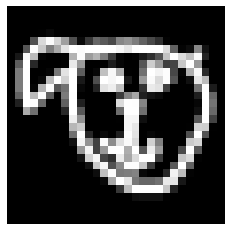

In [3]:
def plot_raster(image):
    plt.imshow(image, cmap="gray")
    plt.axis('off')

dog_sample = dogs[0].reshape(28,28)
plot_raster(dog_sample)

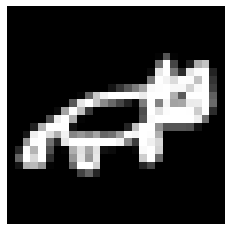

In [4]:
cat_sample = cats[1].reshape(28,28)
plot_raster(cat_sample)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.00392157 0.03137255
  0.         0.         0.         0.         0.         0.
  0.       

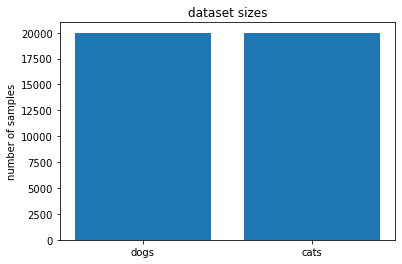

In [5]:
# balance datasets
max_samples = 20000
preprocessed_cats = cats[:max_samples].reshape(-1,28,28)
preprocessed_dogs = dogs[:max_samples].reshape(-1,28,28)

# Normalizing
preprocessed_cats = preprocessed_cats/255
preprocessed_dogs = preprocessed_dogs/255

plt.bar([0,1], [preprocessed_dogs.shape[0], preprocessed_cats.shape[0]])
plt.title('dataset sizes')
plt.xticks([0,1], ['dogs', 'cats'])
plt.ylabel('number of samples');

print(preprocessed_dogs[0])

## Preprocessing data for pytorch

In [6]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

data = np.concatenate((preprocessed_cats, preprocessed_dogs))
labels = np.concatenate((np.zeros(len(preprocessed_cats)), np.ones(len(preprocessed_dogs))))

# include number of channels for pytorch input (amount, channels, height, width)
data = np.expand_dims(data, axis=1)

# split data in train/val/test set
train_val_data, test_data, train_val_labels, test_labels = train_test_split(
    data, 
    labels,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

train_data, val_data, train_labels, val_labels = train_test_split(
    train_val_data, 
    train_val_labels,
    test_size=0.3, 
    random_state=42, 
    shuffle=True
)


In [7]:
import torch

# We select the GPU if we have one, else the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Primary device is {str(device).upper()}")

# pytorch requires data of tensor format, not ndarrays
train_data = torch.tensor(train_data, dtype=torch.float32)
val_data = torch.tensor(val_data, dtype=torch.float32)
test_data = torch.tensor(test_data, dtype=torch.float32)

train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

Primary device is CPU


## Composing and evaluating the model

The final model composed in the [keras object recognition example](./3.object_recognition_with_keras.ipynb) seems to perform pretty well, so let's just remake the structure from there!

In [8]:
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # one grayscale input channel
        input_channels = 1
        
        # 32 channels for every convnet layer
        kernel_depth = 32
        
        # Activation function
        self.act = nn.ReLU()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(input_channels, kernel_depth, kernel_size=5, stride=1, padding=2),
            self.act,
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(kernel_depth, kernel_depth, kernel_size=5, stride=1, padding=2),
            self.act,
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.denselayer1 = nn.Linear(7*7*32, 8)
        self.denselayer2 = nn.Linear(8, 4)
        self.denselayer3 = nn.Linear(4, 2)
    
    def forward(self, x):
        out = self.convlayer1(x.float())
        out = self.convlayer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.act(self.denselayer1(out))
        out = self.act(self.denselayer2(out))
        out = self.denselayer3(out) # No softmax because we are using `CrossEntropyLoss()`
        return out

Like said above, we are **not using a `Softmax()` activation** in the last layer because we define the loss criterion to be `CrossEntropyLoss()`. That is because `CrossEntropyLoss()` [[...] combines LogSoftmax and NLLLoss in one single class.](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). In other words, the Softmax operation is already applied in the loss function.
This criterion expects a class index in the range [0, C-1], so we don't need to one-hot encode the labels.

In [9]:
num_epochs = 2
num_classes = 2
batch_size = 50
learning_rate = 0.001

model = ConvNet()
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
def get_batch(data, labels, index, batch_size, total_step):
    data_slice = slice(index,min(index + batch_size, total_step - 1))
    images = data[data_slice]
    labels = labels[data_slice] 
    images = images.to(device)
    labels = labels.to(device)
    return images, labels

def forward_pass(model, criterion, images, labels):
    outputs = model(images)
    loss = criterion(outputs, labels)
    return outputs.data, loss

def backward_pass(optimizer, loss):
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def compute_accuracy(output_data, labels):
    total = labels.size(0)
    _, predicted = torch.max(output_data, 1)
    correct = (predicted == labels).sum().item()
    
    return correct / total
    

In [11]:
# Train the model
total_step = len(train_data)
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
    
model.train()

for epoch in range(num_epochs):
    
    ##### TRAINING LOOP #####
    for index in range(0, total_step, batch_size):
        images, labels = get_batch(train_data, train_labels, index, batch_size, total_step)
        
        # Run the forward pass
        output_data, loss = forward_pass(model, criterion, images, labels)
        train_loss_list.append(loss.item())

        backward_pass(optimizer, loss)

        # Track the accuracy
        accuracy = compute_accuracy(output_data, labels)
        train_acc_list.append(accuracy)
        
        # Print progress every `nb_batches` batches
        nb_batches = 100
        if index%(batch_size*nb_batches) == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}]," \
                    f"Step [{index + 1}/{total_step}]," \
                    f"Loss: {loss.item() :.4f}," \
                    f"Accuracy: {accuracy * 100 :.2f}%")
                          

    ##### VALIDATION LOOP #####
    epoch_val_acc_list = []
    epoch_val_loss_list = []

    for index in range(0, len(val_data), batch_size):
        images, labels = get_batch(val_data, val_labels, index, batch_size, total_step)

        output_data, loss = forward_pass(model, criterion, images, labels)
        val_loss_list.append(loss.item())
        epoch_val_loss_list.append(loss.item())
        
        # Track the accuracy
        accuracy = compute_accuracy(output_data, labels)
        val_acc_list.append(accuracy)
        epoch_val_acc_list.append(accuracy)
        
    print("VALIDATION SET: " \
             f"Loss: {np.mean(epoch_val_loss_list) :.4f}," \
            f"Accuracy: {np.mean(epoch_val_acc_list) :.2f}%" \
         )

Epoch [1/2],Step [1/22400],Loss: 0.7022,Accuracy: 48.00%
Epoch [1/2],Step [5001/22400],Loss: 0.5243,Accuracy: 68.00%
Epoch [1/2],Step [10001/22400],Loss: 0.5605,Accuracy: 70.00%
Epoch [1/2],Step [15001/22400],Loss: 0.3778,Accuracy: 80.00%
Epoch [1/2],Step [20001/22400],Loss: 0.3657,Accuracy: 88.00%
VALIDATION SET: Loss: 0.3394,Accuracy: 0.85%
Epoch [2/2],Step [1/22400],Loss: 0.4124,Accuracy: 82.00%
Epoch [2/2],Step [5001/22400],Loss: 0.3622,Accuracy: 82.00%
Epoch [2/2],Step [10001/22400],Loss: 0.3800,Accuracy: 84.00%
Epoch [2/2],Step [15001/22400],Loss: 0.2621,Accuracy: 92.00%
Epoch [2/2],Step [20001/22400],Loss: 0.3281,Accuracy: 88.00%
VALIDATION SET: Loss: 0.3018,Accuracy: 0.87%


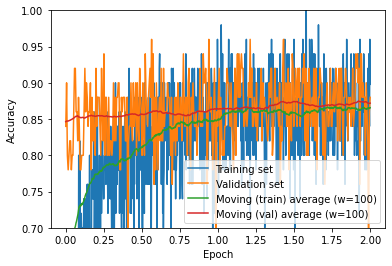

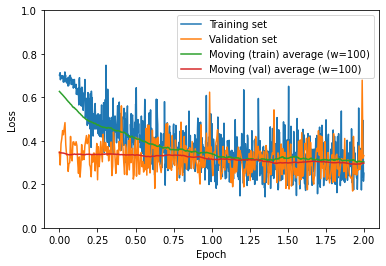

In [12]:
from matplotlib import pyplot as plt

def moving_average(x, w): 
    """Compute the moving average of `x` in a window of `w`"""
    y_axis = np.convolve(x, np.ones(w), 'valid') / w
    
    # This is a hacky approach, do not use this in production
    x_axis = np.linspace(0, num_epochs, len(y_axis))
    return x_axis, y_axis

def plot_moving_average(train_list, val_list, epochs, ma_window, title):
    plt.figure()
    train_x_axis = np.linspace(0, epochs, len(train_list))
    val_x_axis = np.linspace(0, epochs, len(val_list))
    plt.plot(train_x_axis, train_list, label="Training set")
    plt.plot(val_x_axis, val_list, label="Validation set")

    avg_train_x, avg_train_y = moving_average(train_list, window)
    avg_val_x, avg_val_y = moving_average(val_list, window)

    plt.plot(avg_train_x, avg_train_y, label=f"Moving (train) average (w={window})")
    plt.plot(avg_val_x, avg_val_y,  label=f"Moving (val) average (w={window})")
    
    plt.xlabel('Epoch')
    plt.ylabel(title)
    plt.legend(loc='best')
    lower_limit = 0.7 if title == 'Accuracy' else 0 
    plt.ylim(lower_limit, 1)
    
window = 100 # Change the window to have a smoother curve
plot_moving_average(train_acc_list, val_acc_list, num_epochs, window, "Accuracy")
plot_moving_average(train_loss_list, val_loss_list, num_epochs, window, "Loss")

In [13]:
# test model
model.eval()
total_steps = len(test_data)
batch_size = 100
correct = 0
with torch.no_grad():
    for index in range(0, total_steps, batch_size):
        images, labels = get_batch(test_data, test_labels, index, batch_size, total_steps)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total = test_labels.size(0)
        correct_tensor = torch.eq(predicted, labels)
        correct += (predicted == labels).sum().item()

# print final test score
print(f'Test Accuracy of the model on the test images: {(correct / total_steps) * 100 :.2f} %')
# Save the model
torch.save(model.state_dict(), './../models/' + 'conv_net_model.ckpt')

Test Accuracy of the model on the test images: 87.42 %


That final test score looks mighty fine, but that training curve looks so jittery! Can you guess why this is? Discuss with your colleagues! (hint: batch sizes)